In [ ]:
import os, math, time, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Dataset, TensorDataset

# Seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# ** PART A - Tiny ResNet (classification) **

**Cell 2A — Data (MNIST → 64×64 RGB)**

In [ ]:
# Resize MNIST to 64x64 RGB (3 channels) for reasonable compute
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor()
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

BATCH = 128
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.59MB/s]

Train batches: 469 Test batches: 79


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


In [ ]:
class TinyResNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(16)
        # layers with increasing channels and optional downsampling (stride=2)
        self.layer1 = self._make_layer(16, 16, num_blocks=1, stride=1)
        self.layer2 = self._make_layer(16, 32, num_blocks=1, stride=2)
        self.layer3 = self._make_layer(32, 64, num_blocks=1, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, num_classes)
    def _make_layer(self, in_ch, out_ch, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_ch, out_ch, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_ch, out_ch))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# quick instantiate
model_resnet = TinyResNet().to(device)
print(model_resnet)


TinyResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, ep

In [ ]:
def eval_model(model, loader, device):
    model.eval()
    correct = 0; total = 0; loss_sum = 0.0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)
    return loss_sum/total, correct/total

def train_epoch(model, loader, optimizer, device):
    model.train()
    running_loss = 0.0; n = 0
    criterion = nn.CrossEntropyLoss()
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        n += x.size(0)
    return running_loss / n


In [ ]:
opt = optim.Adam(model_resnet.parameters(), lr=0.001)
E = 4  # small for quick demo; increase later
for ep in range(1, E+1):
    t0 = time.time()
    tr_loss = train_epoch(model_resnet, train_loader, opt, device)
    val_loss, val_acc = eval_model(model_resnet, test_loader, device)
    print(f"Epoch {ep}/{E} | train_loss={tr_loss:.4f} | val_loss={val_loss:.4f} | val_acc={100*val_acc:.2f}% | time={time.time()-t0:.1f}s")


Epoch 1/4 | train_loss=0.6195 | val_loss=0.2183 | val_acc=94.65% | time=31.0s
Epoch 2/4 | train_loss=0.1204 | val_loss=0.2380 | val_acc=92.81% | time=29.4s
Epoch 3/4 | train_loss=0.0787 | val_loss=0.0793 | val_acc=97.79% | time=28.9s
Epoch 4/4 | train_loss=0.0619 | val_loss=0.1009 | val_acc=97.01% | time=30.1s


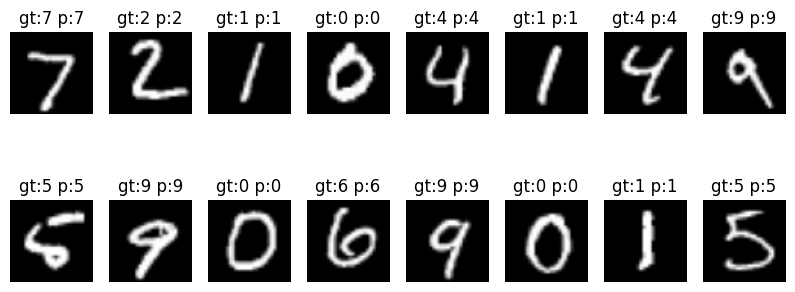

In [ ]:
model_resnet.eval()
x,y = next(iter(test_loader))
x,y = x.to(device), y.to(device)
with torch.no_grad():
    out = model_resnet(x[:16])
    _, p = out.max(1)
fig = plt.figure(figsize=(10,4))
for i in range(16):
    ax = fig.add_subplot(2,8,i+1)
    img = x[i].cpu().permute(1,2,0).numpy()
    plt.imshow(img[:,:,0], cmap='gray')
    ax.set_title(f"gt:{y[i].item()} p:{p[i].item()}")
    ax.axis('off')
plt.show()


# PART B — Skip Connections Demo (manually adding skip)

**Cell 8B — Small CNN without skip and with skip (compare)**

In [ ]:
class SimpleNoSkip(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,16,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(16*16*16, 10)
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)

class SimpleWithSkip(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,16,3,padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(16*16*16, 10)
    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        residual = out
        out = F.relu(self.bn2(self.conv2(out)))
        out = out + residual   # skip connection
        out = self.pool(out)
        out = out.view(out.size(0),-1)
        return self.fc(out)

# quick instantiate
noskip = SimpleNoSkip().to(device)
wskip = SimpleWithSkip().to(device)
print("NoSkip:", noskip)
print("WithSkip:", wskip)


NoSkip: SimpleNoSkip(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)
WithSkip: SimpleWithSkip(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=4096, out_features=10, bias=True)
)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------------------
# 1. No-Skip CNN
# ---------------------------
class NoSkipCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   # FIXED → 3 channels
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(32 * 16 * 16, 10)  # (64→32→16)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # (3,64,64) → (32,64,64)
        x = self.pool(x)            # (32,32,32)
        x = F.relu(self.conv2(x))   # (32,32,32)
        x = self.pool(x)            # (32,16,16)
        x = x.flatten(1)
        return self.fc(x)


# ---------------------------
# 2. Tiny-ResNet with Skip Connection
# ---------------------------
class SkipBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)

    def forward(self, x):
        identity = x
        out = F.relu(self.conv1(x))
        out = self.conv2(out)
        return F.relu(out + identity)  # skip connection


class TinyResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, 3, padding=1)  # FIXED → 3 channels
        self.block = SkipBlock(32)
        self.pool = nn.MaxPool2d(2,2)
        self.fc = nn.Linear(32 * 16 * 16, 10)

    def forward(self, x):
        x = F.relu(self.conv(x))     # (3,64,64) → (32,64,64)
        x = self.block(x)            # skip block
        x = self.pool(x)             # (32,32,32)
        x = self.pool(x)             # (32,16,16)
        x = x.flatten(1)
        return self.fc(x)


# ---------------------------
# 3. Train function
# ---------------------------
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()


# ---------------------------
# 4. Test function
# ---------------------------
def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


# ---------------------------
# 5. Train & Evaluate both
# ---------------------------
noskip = NoSkipCNN().to(device)
skipnet = TinyResNet().to(device)

print("Training No-Skip CNN...")
train_one_epoch(noskip)

print("Training TinyResNet (with skip)...")
train_one_epoch(skipnet)

print("\nEVALUATION:")
acc1 = evaluate(noskip)
acc2 = evaluate(skipnet)

print(f"No-Skip CNN Accuracy:   {acc1*100:.2f}%")
print(f"Skip-Connection Accuracy: {acc2*100:.2f}%")


Training No-Skip CNN...
Training TinyResNet (with skip)...

EVALUATION:
No-Skip CNN Accuracy:   97.53%
Skip-Connection Accuracy: 97.64%


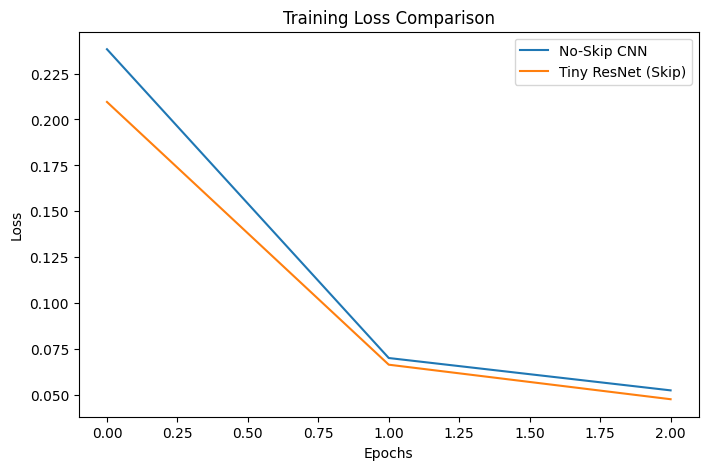

In [ ]:
import matplotlib.pyplot as plt

# Quick function to track loss during training
def train_with_tracking(model, epochs=3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
    return losses

# Track losses for both models
loss_noskip = train_with_tracking(NoSkipCNN().to(device))
loss_skip = train_with_tracking(TinyResNet().to(device))

# Plot
plt.figure(figsize=(8,5))
plt.plot(loss_noskip, label="No-Skip CNN")
plt.plot(loss_skip, label="Tiny ResNet (Skip)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()


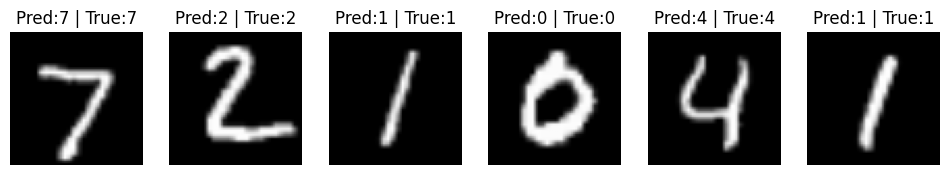

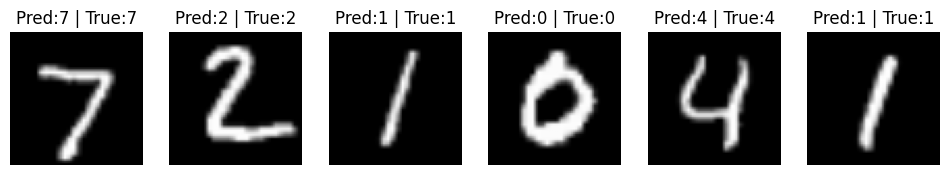

In [ ]:
def show_predictions(model, n=6):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    preds = outputs.argmax(1)

    plt.figure(figsize=(12,3))
    for i in range(n):
        plt.subplot(1,n,i+1)
        img = images[i].cpu().permute(1,2,0)  # (C,H,W) -> (H,W,C)
        plt.imshow(img)
        plt.title(f"Pred:{preds[i].item()} | True:{labels[i].item()}")
        plt.axis('off')
    plt.show()

show_predictions(noskip)
show_predictions(skipnet)
